# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from tqdm import tqdm

In [2]:
from model import Critic, Generator, init_weights
from utils import gradient_penalty, save_checkpoint, load_checkpoint

In [3]:
# Setting manual seed for reproducibility
manual_seed = 999
print(f"Random Seed: {manual_seed}")
torch.manual_seed(manual_seed)

Random Seed: 999


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Pytorch version: {torch.__version__}")
print(f"Device: {device}")

Pytorch version: 1.13.0+cu117
Device: cuda


In [5]:
# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
IMAGE_SHAPE = (CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)
Z_DIM = 250
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

NGPU = 2

In [6]:
transform = transforms.Compose(
    [
        transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

Dataset length: 5216
Dataset classes: ['NORMAL', 'PNEUMONIA']
Dataset class to idx mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Dataset sample: ('../data/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg', 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


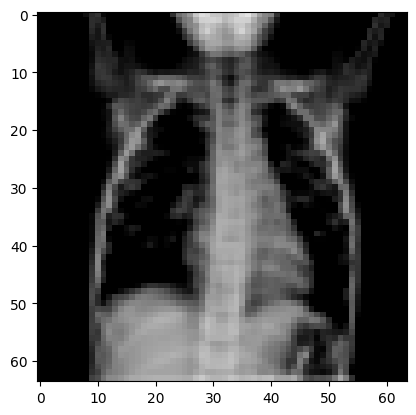

In [7]:
# Load dataset from data/chest_xray/train
dataset = datasets.ImageFolder(root="../data/chest_xray/train", transform=transform)

print(f"Dataset length: {len(dataset)}")
print(f"Dataset classes: {dataset.classes}")
print(f"Dataset class to idx mapping: {dataset.class_to_idx}")

print(f"Dataset sample: {dataset.samples[0]}")

plt.imshow(dataset[0][0].permute(1, 2, 0))
plt.show()

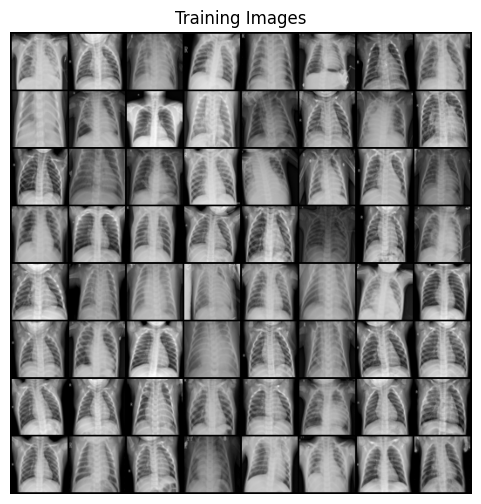

In [8]:
loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

# Print sample batch
# for batch_idx, (data, targets) in enumerate(loader):
#     print(f"Batch idx: {batch_idx}")
#     print(f"Data shape: {data.shape}")
#     print(f"Targets shape: {targets.shape}")
#     print(f"Targets: {targets}")
#     plt.figure(figsize=(8, 8))
#     plt.axis("off")
#     plt.imshow(
#         np.transpose(
#             vutils.make_grid(data.to(device)[:64], padding=2, normalize=True).cpu(),
#             (1, 2, 0),
#         )
#     )
#     plt.show()
#     break


# Print sample batch
real_batch = next(iter(loader))
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),
        (1, 2, 0),
    )
)
plt.show()

In [9]:
generator: Generator = Generator(Z_DIM, IMAGE_SHAPE, FEATURES_GEN, NGPU).to(device)

if device == "cuda" and NGPU > 1:
    generator = nn.DataParallel(generator, list(range(NGPU)))

init_weights(generator)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(250, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
critic: Critic = Critic(IMAGE_SHAPE, FEATURES_CRITIC, NGPU).to(device)

if device == "cuda" and NGPU > 1:
    critic = nn.DataParallel(critic, list(range(NGPU)))

init_weights(critic)
print(critic)

Critic(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [11]:
# Optimizer for generator
opt_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
print(opt_gen)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.0, 0.9)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [12]:
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
print(opt_critic)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.0, 0.9)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [13]:
# Tensorboard
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")

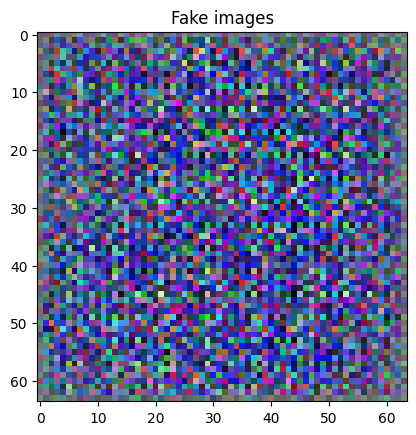

In [14]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
plt.imshow(
    np.transpose(
        vutils.make_grid(
            generator(fixed_noise).detach().cpu()[:1], padding=2, normalize=True
        ),
        (1, 2, 0),
    )
)
plt.title("Fake images")
plt.show()

In [15]:
step = 0
generator_losses = []
critic_losses = []

In [16]:
generator.train()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(250, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [17]:
critic.train()

Critic(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [0/100] Batch 0/82                       Loss D: 56.8638, loss G: -0.1130


100%|██████████| 82/82 [01:21<00:00,  1.00it/s]


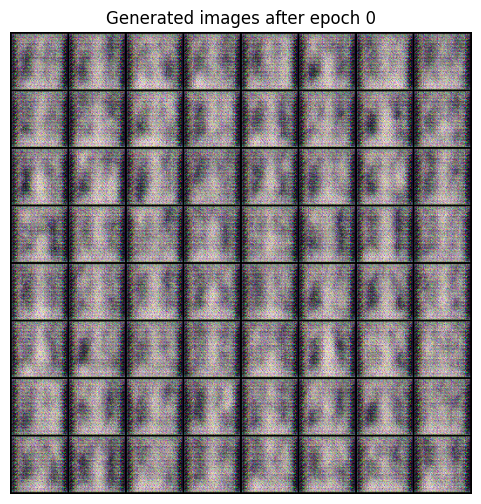

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [1/100] Batch 0/82                       Loss D: -7.3603, loss G: 6.3906


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [2/100] Batch 0/82                       Loss D: -3.9668, loss G: 4.1129


  1%|          | 1/82 [00:09<12:29,  9.26s/it]

Epoch [3/100] Batch 0/82                       Loss D: -4.2870, loss G: 3.1868


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [4/100] Batch 0/82                       Loss D: -4.1380, loss G: 4.5865


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [5/100] Batch 0/82                       Loss D: -4.1013, loss G: 3.5121


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [6/100] Batch 0/82                       Loss D: -3.0382, loss G: 4.0807


  1%|          | 1/82 [00:08<10:59,  8.14s/it]

Epoch [7/100] Batch 0/82                       Loss D: -3.8986, loss G: 2.5546


  1%|          | 1/82 [00:08<11:17,  8.37s/it]

Epoch [8/100] Batch 0/82                       Loss D: -4.4591, loss G: 2.1669


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [9/100] Batch 0/82                       Loss D: -3.9933, loss G: 5.4905


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [10/100] Batch 0/82                       Loss D: -4.0315, loss G: -1.1448


100%|██████████| 82/82 [01:17<00:00,  1.06it/s]


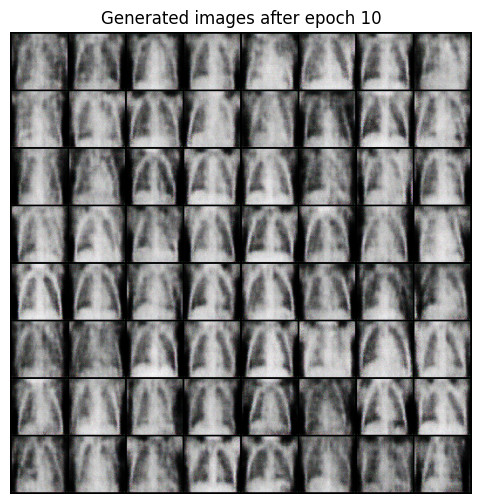

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [11/100] Batch 0/82                       Loss D: -4.5541, loss G: 3.9939


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [12/100] Batch 0/82                       Loss D: -4.3960, loss G: 2.1234


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [13/100] Batch 0/82                       Loss D: -4.4329, loss G: 2.8171


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [14/100] Batch 0/82                       Loss D: -3.3645, loss G: -1.3501


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [15/100] Batch 0/82                       Loss D: -4.0019, loss G: -0.9753


  1%|          | 1/82 [00:08<10:52,  8.05s/it]

Epoch [16/100] Batch 0/82                       Loss D: -4.5711, loss G: -1.2068


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [17/100] Batch 0/82                       Loss D: -3.4884, loss G: 0.4298


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [18/100] Batch 0/82                       Loss D: -4.5700, loss G: 4.0073


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [19/100] Batch 0/82                       Loss D: -3.9670, loss G: -4.4877


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [20/100] Batch 0/82                       Loss D: -3.5717, loss G: -0.1522


100%|██████████| 82/82 [01:14<00:00,  1.10it/s]


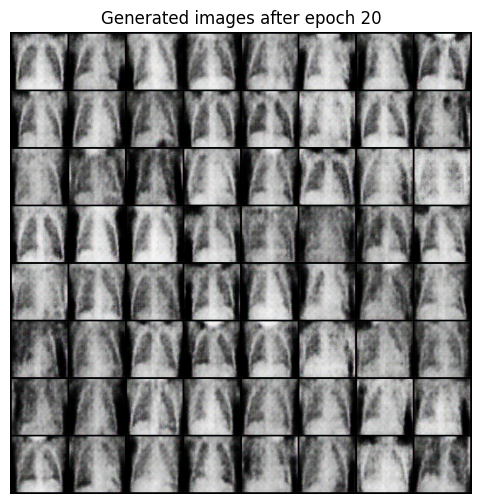

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [21/100] Batch 0/82                       Loss D: -3.0593, loss G: -0.2393


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [22/100] Batch 0/82                       Loss D: -3.3835, loss G: -1.7914


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [23/100] Batch 0/82                       Loss D: -3.1652, loss G: -0.8430


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [24/100] Batch 0/82                       Loss D: -3.5555, loss G: -2.6048


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [25/100] Batch 0/82                       Loss D: -3.3951, loss G: 4.0547


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [26/100] Batch 0/82                       Loss D: -4.2828, loss G: 5.0445


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [27/100] Batch 0/82                       Loss D: -3.6445, loss G: -5.6452


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [28/100] Batch 0/82                       Loss D: -4.4258, loss G: -3.9476


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [29/100] Batch 0/82                       Loss D: -3.0503, loss G: -2.1941


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [30/100] Batch 0/82                       Loss D: -3.0734, loss G: -2.7591


100%|██████████| 82/82 [01:14<00:00,  1.10it/s]


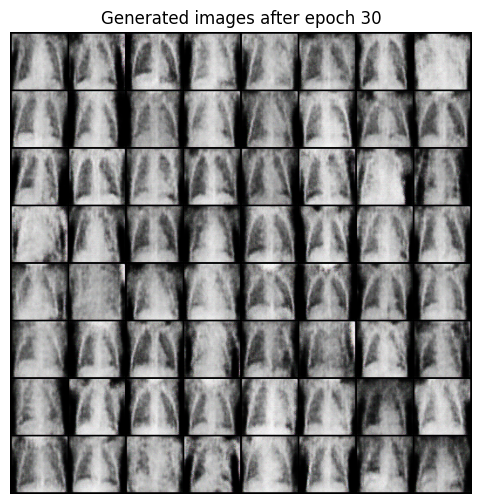

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [31/100] Batch 0/82                       Loss D: -3.0903, loss G: -2.7671


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [32/100] Batch 0/82                       Loss D: -3.5225, loss G: -4.2954


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [33/100] Batch 0/82                       Loss D: -3.9543, loss G: -6.1774


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [34/100] Batch 0/82                       Loss D: -2.6876, loss G: -3.4797


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [35/100] Batch 0/82                       Loss D: -1.7671, loss G: -4.7782


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [36/100] Batch 0/82                       Loss D: -2.7867, loss G: -7.0165


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [37/100] Batch 0/82                       Loss D: -3.5619, loss G: -2.2184


  1%|          | 1/82 [00:08<11:05,  8.21s/it]

Epoch [38/100] Batch 0/82                       Loss D: -4.0911, loss G: 0.4366


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [39/100] Batch 0/82                       Loss D: -2.6582, loss G: -1.3196


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [40/100] Batch 0/82                       Loss D: -3.0343, loss G: -2.6796


100%|██████████| 82/82 [01:14<00:00,  1.10it/s]


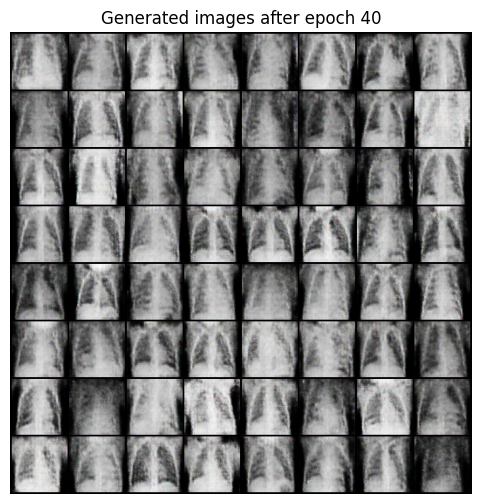

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [41/100] Batch 0/82                       Loss D: -3.1683, loss G: -3.5462


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [42/100] Batch 0/82                       Loss D: -3.0975, loss G: 0.1218


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [43/100] Batch 0/82                       Loss D: -3.4639, loss G: -5.4539


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [44/100] Batch 0/82                       Loss D: -2.6565, loss G: -2.2205


  1%|          | 1/82 [00:08<11:54,  8.83s/it]

Epoch [45/100] Batch 0/82                       Loss D: -3.4425, loss G: -3.1765


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [46/100] Batch 0/82                       Loss D: -2.8334, loss G: -0.0880


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [47/100] Batch 0/82                       Loss D: -2.4575, loss G: -1.4619


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [48/100] Batch 0/82                       Loss D: -2.7389, loss G: 0.3453


  1%|          | 1/82 [00:08<11:42,  8.67s/it]

Epoch [49/100] Batch 0/82                       Loss D: -2.7190, loss G: -5.1369


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [50/100] Batch 0/82                       Loss D: -2.8524, loss G: -2.5916


100%|██████████| 82/82 [01:15<00:00,  1.09it/s]


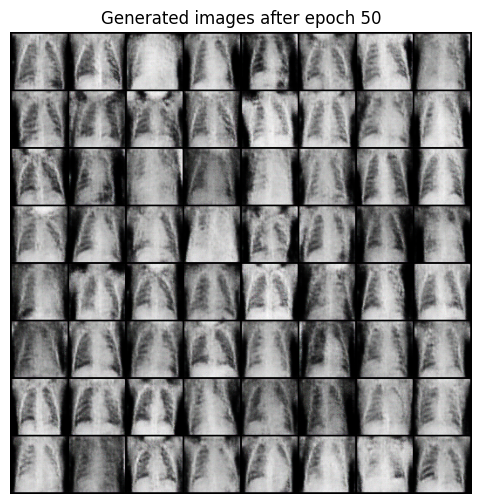

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [51/100] Batch 0/82                       Loss D: -2.6016, loss G: -2.9043


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [52/100] Batch 0/82                       Loss D: -3.5284, loss G: -1.8619


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [53/100] Batch 0/82                       Loss D: -3.7358, loss G: -5.1798


  1%|          | 1/82 [00:08<11:13,  8.32s/it]

Epoch [54/100] Batch 0/82                       Loss D: -2.9354, loss G: -5.4740


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [55/100] Batch 0/82                       Loss D: -2.6355, loss G: -4.2002


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [56/100] Batch 0/82                       Loss D: -2.8969, loss G: -10.6285


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [57/100] Batch 0/82                       Loss D: -2.4470, loss G: -4.9189


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [58/100] Batch 0/82                       Loss D: -3.1180, loss G: -0.6946


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [59/100] Batch 0/82                       Loss D: -2.2428, loss G: -4.7205


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [60/100] Batch 0/82                       Loss D: -2.1457, loss G: -3.5997


100%|██████████| 82/82 [01:14<00:00,  1.09it/s]


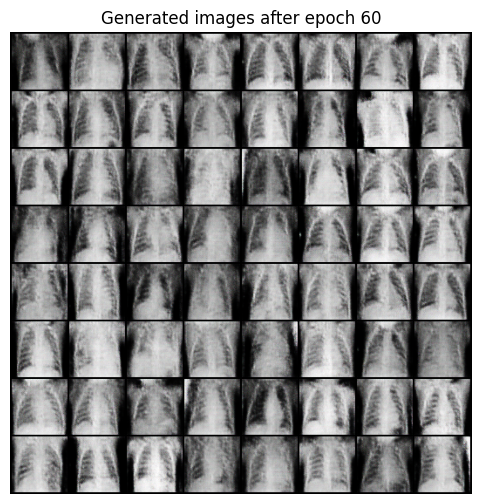

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [61/100] Batch 0/82                       Loss D: -1.7686, loss G: -6.6641


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [62/100] Batch 0/82                       Loss D: -2.6044, loss G: -4.7871


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [63/100] Batch 0/82                       Loss D: -2.4296, loss G: -4.8631


  1%|          | 1/82 [00:08<10:59,  8.15s/it]

Epoch [64/100] Batch 0/82                       Loss D: -1.4949, loss G: -3.1201


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [65/100] Batch 0/82                       Loss D: -2.8786, loss G: -4.9761


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [66/100] Batch 0/82                       Loss D: -2.8200, loss G: -5.6827


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [67/100] Batch 0/82                       Loss D: -2.1308, loss G: -7.2300


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [68/100] Batch 0/82                       Loss D: -2.4548, loss G: -4.6647


  1%|          | 1/82 [00:08<11:42,  8.68s/it]

Epoch [69/100] Batch 0/82                       Loss D: -2.4309, loss G: -4.7733


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [70/100] Batch 0/82                       Loss D: -2.1251, loss G: -7.4481


100%|██████████| 82/82 [01:14<00:00,  1.11it/s]


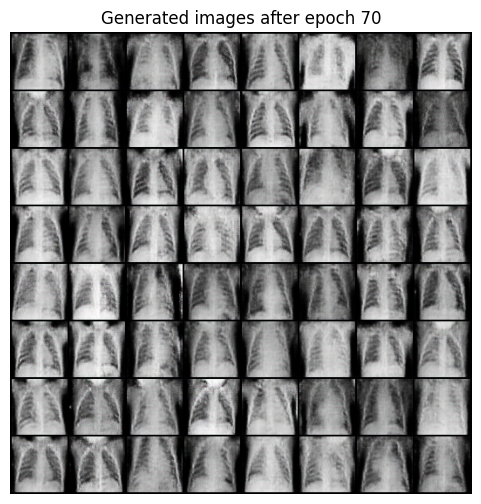

  1%|          | 1/82 [00:08<10:54,  8.08s/it]

Epoch [71/100] Batch 0/82                       Loss D: -2.1389, loss G: -4.6857


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [72/100] Batch 0/82                       Loss D: -2.9653, loss G: -4.8367


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [73/100] Batch 0/82                       Loss D: -1.9765, loss G: -6.0229


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [74/100] Batch 0/82                       Loss D: -1.6220, loss G: -9.7659


  1%|          | 1/82 [00:08<10:53,  8.07s/it]

Epoch [75/100] Batch 0/82                       Loss D: -2.8550, loss G: -5.8356


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [76/100] Batch 0/82                       Loss D: -2.7158, loss G: -9.3206


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [77/100] Batch 0/82                       Loss D: -2.4429, loss G: -8.4881


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [78/100] Batch 0/82                       Loss D: -1.8921, loss G: -9.4686


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [79/100] Batch 0/82                       Loss D: -3.4804, loss G: -9.4039


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [80/100] Batch 0/82                       Loss D: -2.3120, loss G: -5.8841


100%|██████████| 82/82 [01:15<00:00,  1.09it/s]


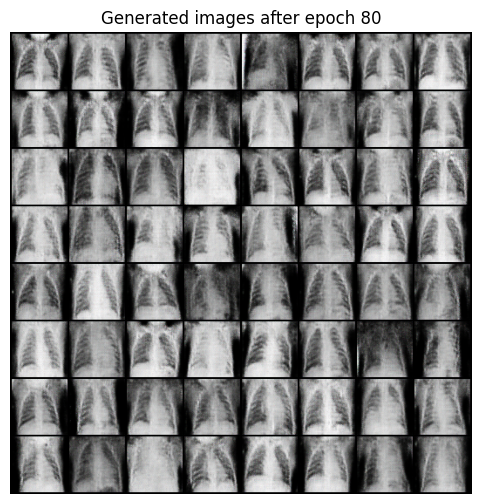

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [81/100] Batch 0/82                       Loss D: -3.0320, loss G: -9.3246


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [82/100] Batch 0/82                       Loss D: -2.3432, loss G: -2.1110


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [83/100] Batch 0/82                       Loss D: -2.9239, loss G: -4.6307


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [84/100] Batch 0/82                       Loss D: -2.5720, loss G: -0.4028


  1%|          | 1/82 [00:08<11:23,  8.44s/it]

Epoch [85/100] Batch 0/82                       Loss D: -2.2879, loss G: -2.5808


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [86/100] Batch 0/82                       Loss D: -2.4912, loss G: -7.8131


  1%|          | 1/82 [00:08<11:27,  8.49s/it]

Epoch [87/100] Batch 0/82                       Loss D: -2.2164, loss G: -6.0952


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [88/100] Batch 0/82                       Loss D: -3.1839, loss G: -2.0978


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [89/100] Batch 0/82                       Loss D: -1.8228, loss G: -8.4400


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [90/100] Batch 0/82                       Loss D: -1.6945, loss G: -7.1482


100%|██████████| 82/82 [01:15<00:00,  1.09it/s]


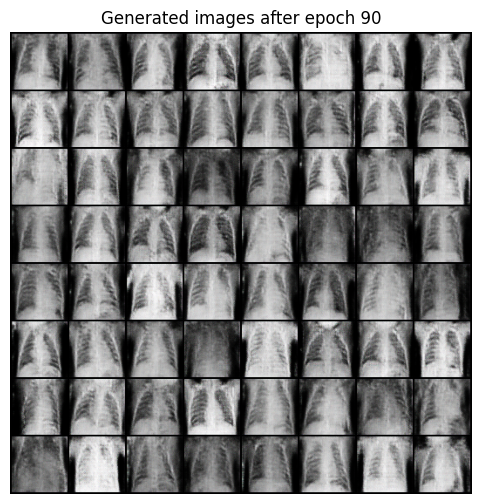

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [91/100] Batch 0/82                       Loss D: -1.9062, loss G: -6.8871


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [92/100] Batch 0/82                       Loss D: -2.2053, loss G: -10.5021


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [93/100] Batch 0/82                       Loss D: -3.3069, loss G: -9.9704


  1%|          | 1/82 [00:08<11:32,  8.55s/it]

Epoch [94/100] Batch 0/82                       Loss D: -2.2382, loss G: -10.4656


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [95/100] Batch 0/82                       Loss D: -1.9816, loss G: -10.0152


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [96/100] Batch 0/82                       Loss D: -1.7570, loss G: -7.3058


  1%|          | 1/82 [00:08<11:15,  8.34s/it]

Epoch [97/100] Batch 0/82                       Loss D: -2.3662, loss G: -13.4345


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [98/100] Batch 0/82                       Loss D: -1.8277, loss G: -10.5582


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch [99/100] Batch 0/82                       Loss D: -3.0561, loss G: -2.4868


100%|██████████| 82/82 [01:15<00:00,  1.09it/s]


In [18]:
%matplotlib inline
for epoch in range(NUM_EPOCHS):
    # print(f"Starting Epoch: {epoch}")
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # => min -E[critic(real)] + E[critic(fake)]
        critic_loss = 0
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = generator(noise)

            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)

            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            critic_loss += loss_critic.item()
        
        critic_losses.append(critic_loss / CRITIC_ITERATIONS)

        # Train Generator: min -E[critic(gen_fake)] <-> max E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        generator_losses.append(loss_gen.item())

        # Print losses occasionally and print to tensorboard
        if (batch_idx == 0) or (batch_idx == len(loader)):
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = generator(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = vutils.make_grid(
                    real[:32], normalize=True, padding=2
                )
                img_grid_fake = vutils.make_grid(
                    fake[:32], normalize=True, padding=2
                )

                writer_real.add_image(
                    "Real images", img_grid_real, global_step=step
                )
                writer_fake.add_image("Fake images", img_grid_fake, global_step=step)

            step += 1
    
    # Save model after each epoch
    if epoch % 10 == 0:
        torch.save(generator.state_dict(), f"model_states/generator_epoch_{epoch}.pth")
        torch.save(critic.state_dict(), f"model_states/critic_epoch_{epoch}.pth")

        # Print images after each epoch
        with torch.no_grad():
            sample_noise = torch.randn(64, Z_DIM, 1, 1).to(device)
            sample = generator(sample_noise)
            plt.figure(figsize=(6, 6))
            plt.axis("off")
            plt.title(f"Generated images after epoch {epoch}")
            plt.imshow(
                np.transpose(
                    vutils.make_grid(sample[:64], padding=2, normalize=True).cpu(),
                    (1, 2, 0),
                )
            )
            plt.show()

# Save model after training
torch.save(generator.state_dict(), "generator.pth")
torch.save(critic.state_dict(), "critic.pth")

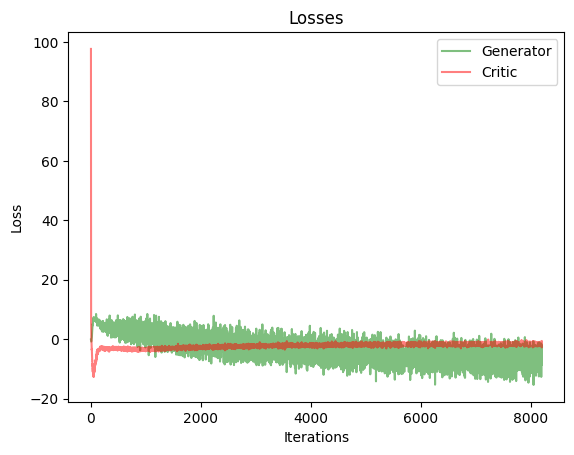

In [19]:
# Plot losses
plt.plot(generator_losses, label="Generator", alpha=0.5, color="green")
plt.plot(critic_losses, label="Critic", alpha=0.5, color="red")
plt.title("Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

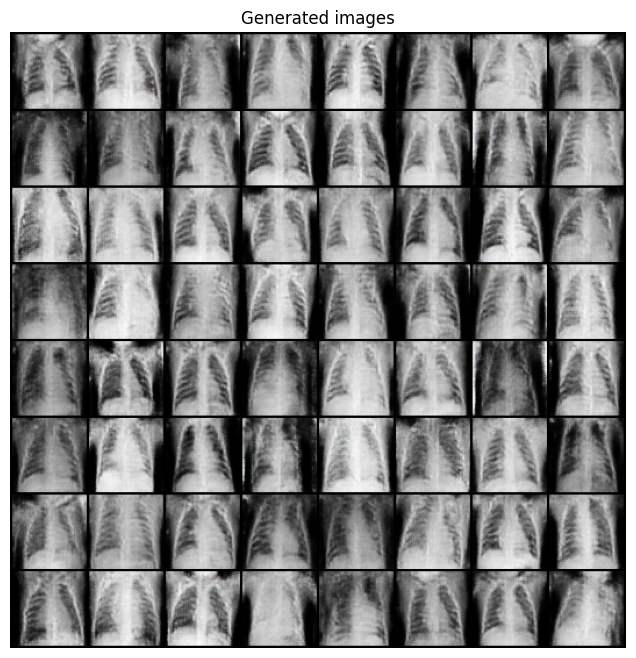

In [20]:
# Plot some images
with torch.no_grad():
    sample_noise = torch.randn(64, Z_DIM, 1, 1).to(device)
    sample = generator(sample_noise)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(sample[:64], padding=2, normalize=True).cpu(),
            (1, 2, 0),
        )
    )
    plt.show()

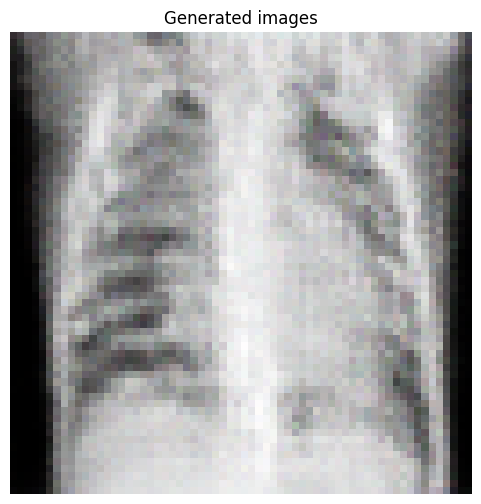

In [21]:
# Load model after training and generate images
gen = Generator(Z_DIM, IMAGE_SHAPE, FEATURES_GEN, NGPU).to(device)
gen.load_state_dict(torch.load("generator.pth"))
gen.eval()

with torch.no_grad():
    sample_noise = torch.randn(64, Z_DIM, 1, 1).to(device)
    sample = gen(sample_noise)
    plt.figure(figsize=(6, 6))
    plt.axis("off")
    plt.title("Generated images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(sample[:1], padding=2, normalize=True).cpu(),
            (1, 2, 0),
        )
    )
    plt.show()